In [1]:
import pandas as pd
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pmdarima as pm
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima

import torch
from torch.nn.functional import mse_loss

import utils

In [3]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import acf, pacf
from datetime import datetime
from scipy import stats
from scipy.stats import boxcox
import statsmodels.tsa as smt

In [4]:
df = pd.read_csv("./krwkzt.csv")
df.head()

,Date,Close
0,02/01/2004 23:58:00,"0,115788868"
1,05/01/2004 23:58:00,"0,114777432"
2,06/01/2004 23:58:00,"0,115528245"
3,07/01/2004 23:58:00,"0,11447919"
4,08/01/2004 23:58:00,"0,115056396"


In [5]:
df["Close"] = df.Close.map(lambda x: np.float32(x.replace(",", ".")))

In [6]:
df["Date"] = df.Date.map(lambda x: pd.to_datetime(x, dayfirst=True).date())

In [7]:
df = df.set_index("Date")
df.head()

,Close
Date,
2004-01-02,0.115789
2004-01-05,0.114777
2004-01-06,0.115528
2004-01-07,0.114479
2004-01-08,0.115056


<Axes: xlabel='Date'>

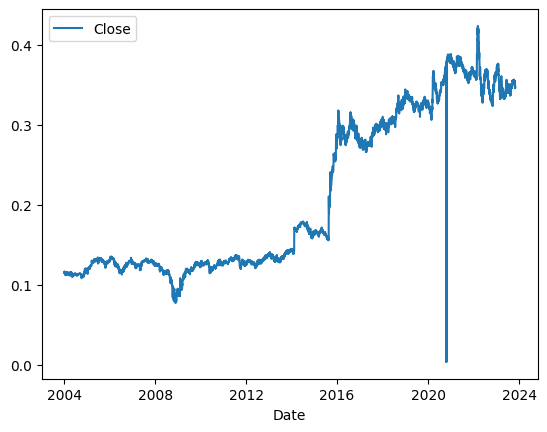

In [8]:
df.plot()

In [12]:
df[df["Close"] < 0.01]

,Close
Date,
2020-10-17,0.003759
2020-10-18,0.003759
2020-10-24,0.003792


In [13]:
df[df["Close"] < 0.01] = np.NaN
df.values

array([[0.11578887],
       [0.11477743],
       [0.11552825],
       ...,
       [0.3460535 ],
       [0.34943968],
       [0.34686083]], dtype=float32)

In [14]:
df = df.interpolate()

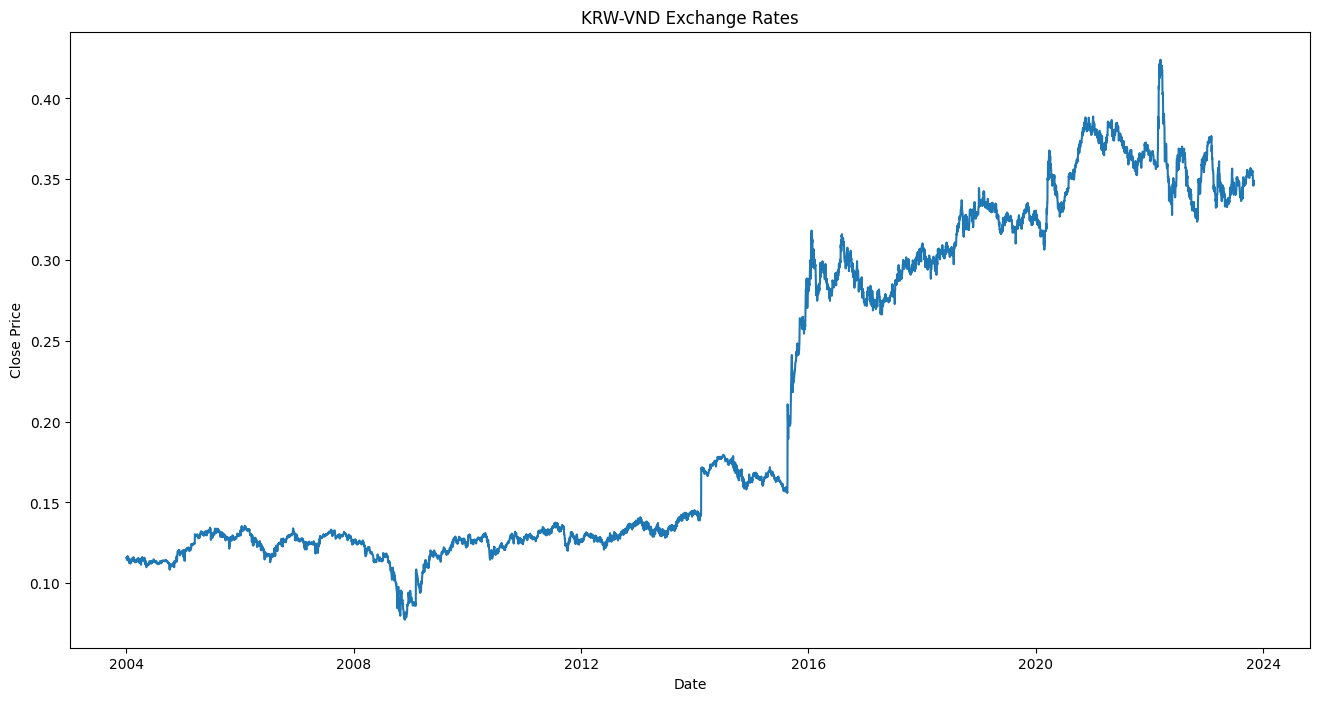

In [15]:
plt.figure(figsize=(16,8))
plt.plot(df)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("KRW-VND Exchange Rates")
plt.show()

In [16]:
df.to_csv("./preprocessed-data/krwkzt.csv")

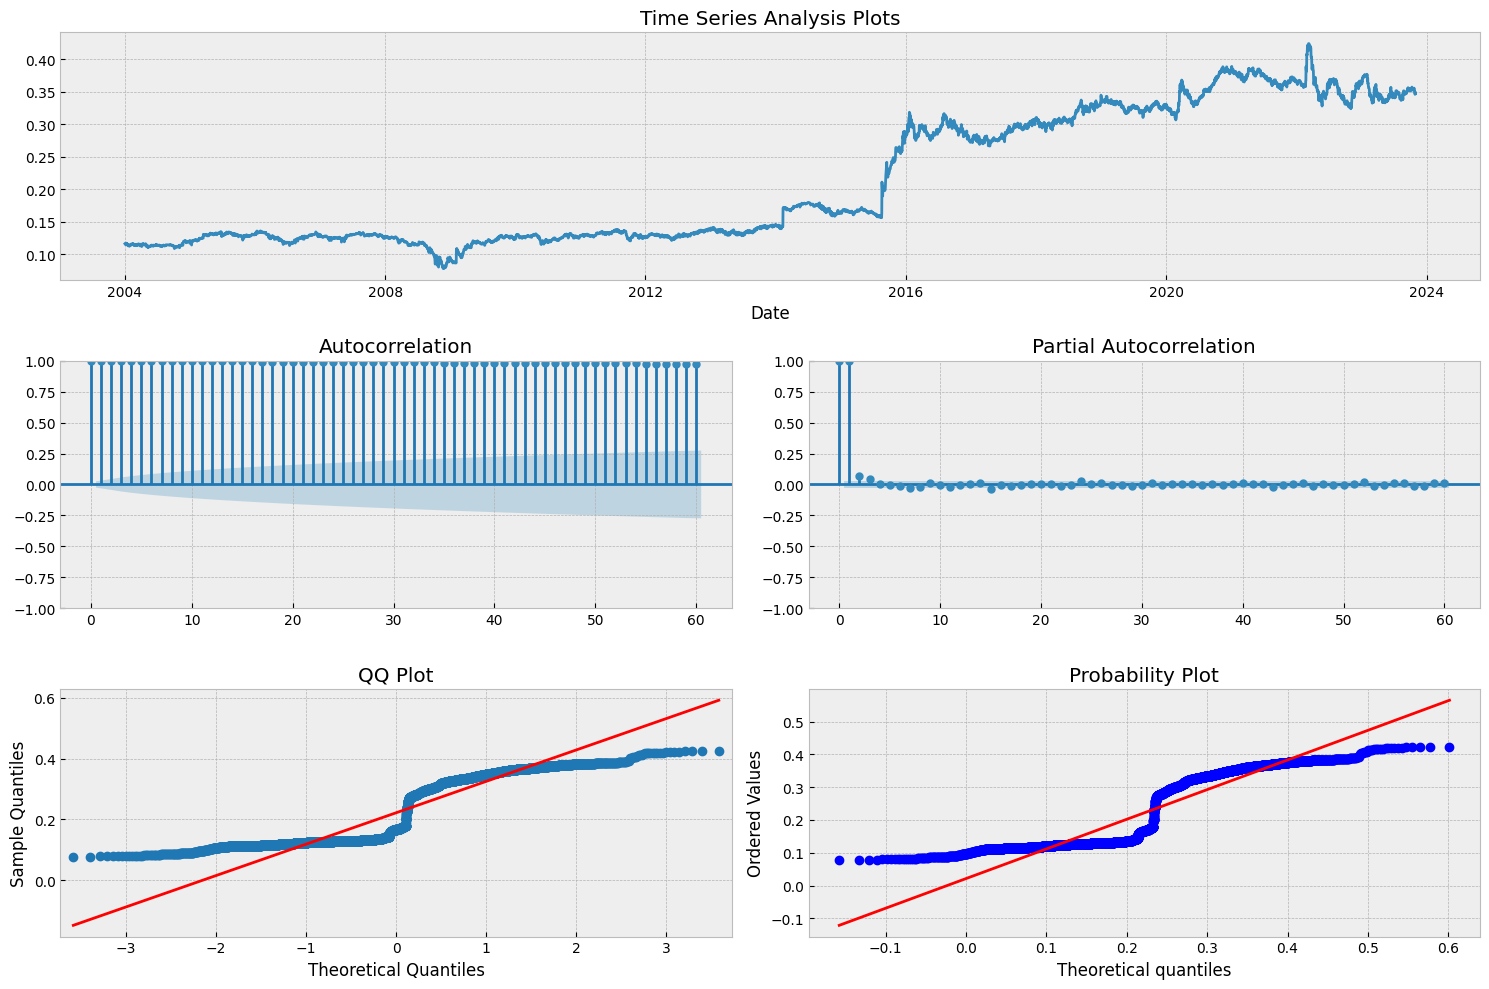

In [18]:
raw_data = utils.tsplot(df['Close'], lags=60)

In [19]:
#1st diffrence
diff_df = df.diff(periods=1).iloc[1:]

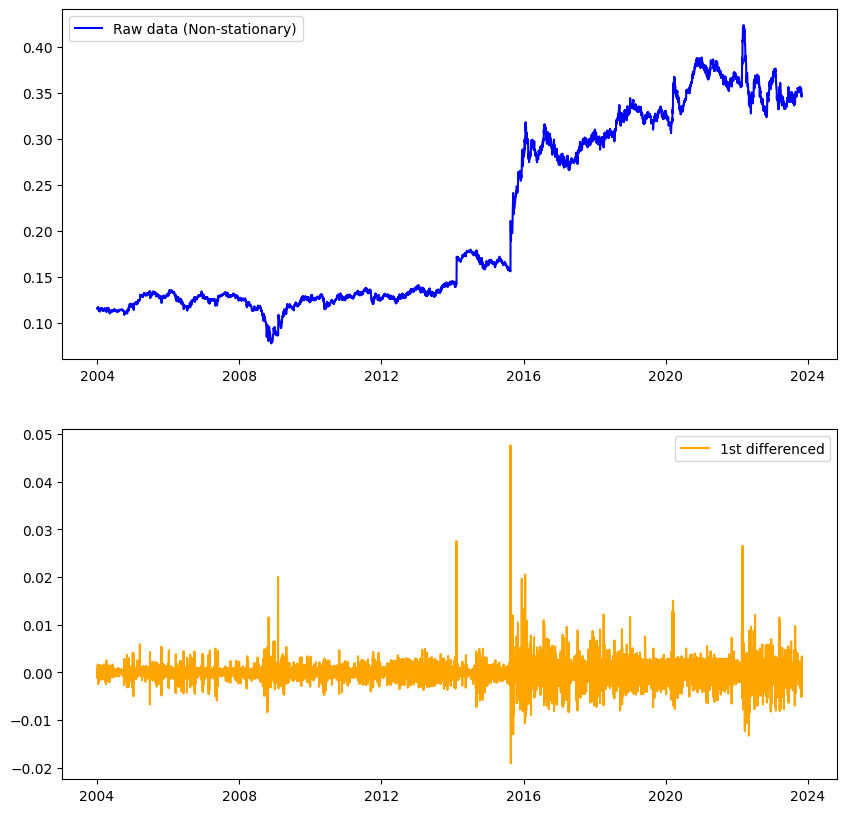

In [20]:
plt.figure(figsize=(10,10))

ax1 = plt.subplot(211)
ax1.plot(df, color="blue")
ax1.legend(['Raw data (Non-stationary)'])

ax2 =plt.subplot(212)
ax2.plot(diff_df, color="orange")
ax2.legend(['1st differenced'])

In [21]:
# ADF test

adf_test = adfuller(diff_df)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %20.20f' % adf_test[1])

ADF Statistic: -15.151101
Critical Values @ 0.05: -2.86
p-value: 0.00000000000000000000


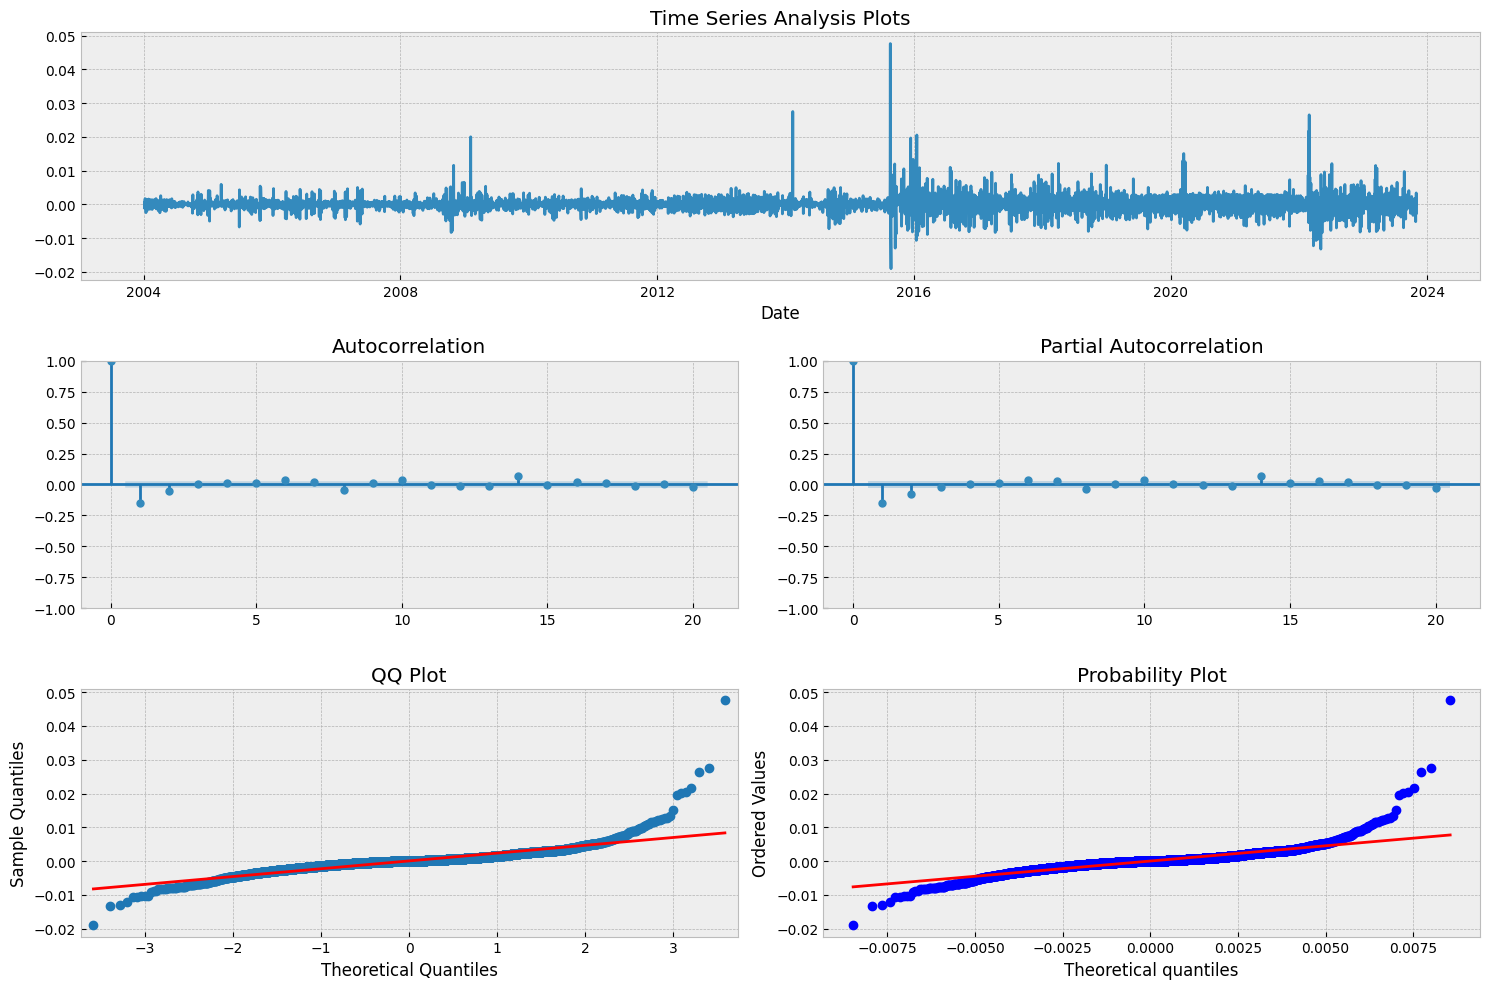

In [22]:
diff_plot= utils.tsplot(diff_df["Close"], lags=20)

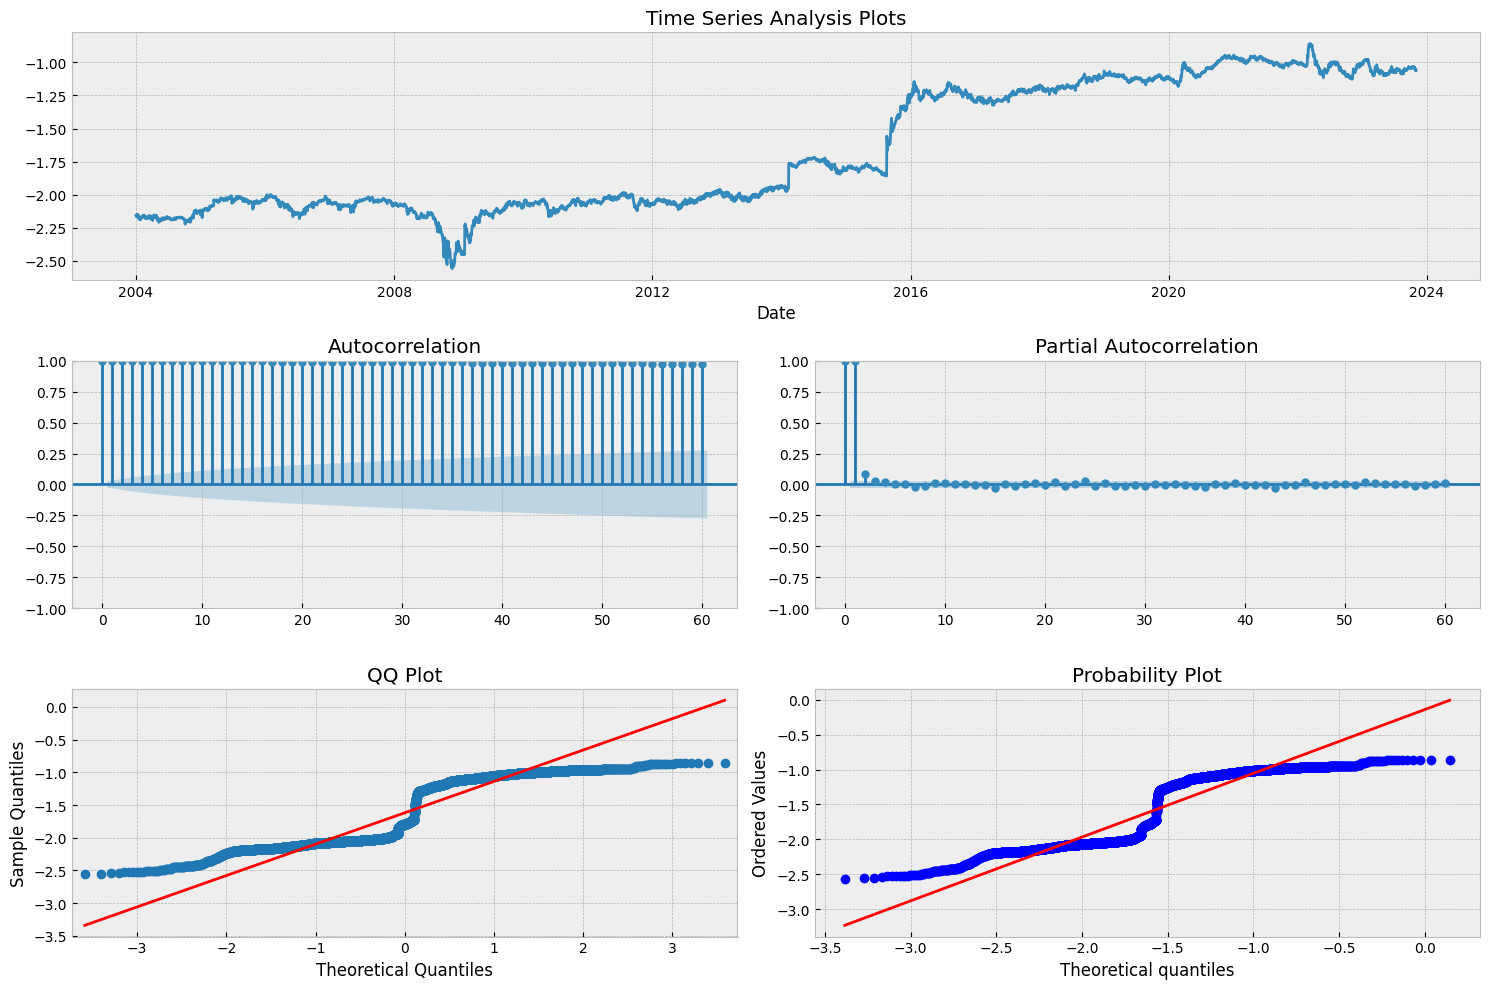

In [23]:
df_log = df.copy()
df_log["Close"] = np.log(df["Close"])
utils.tsplot(df_log["Close"], lags=60)

In [66]:
model = pm.auto_arima(df, d=2,
                      start_p=0, start_q=0, max_order=10, test='adf',
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-50411.451, Time=0.30 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-52466.043, Time=0.29 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-54810.418, Time=0.56 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=3.07 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-55231.404, Time=0.96 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-55264.126, Time=1.26 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-55186.063, Time=2.40 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=-55272.495, Time=1.59 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=-55299.198, Time=4.34 sec
 ARIMA(0,2,4)(0,0,0)[0]             : AIC=-55378.657, Time=3.89 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=-55325.552, Time=4.25 sec
 ARIMA(0,2,5)(0,0,0)[0]             : AIC=-50401.781, Time=6.25 sec
 ARIMA(1,2,5)(0,0,0)[0]             : AIC=-55460.516, Time=9.99 sec
 ARIMA(2,2,5)(0,0,0)[0]             : AIC=-50397.308, Time=8.33 sec
 ARIMA(2,2,4

In [67]:
# create model
model = sm.tsa.arima.ARIMA(df_log, order=(1,2,5))
results = model.fit()

print(results.summary())

/home/kurone/anaconda3/envs/tsa/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/kurone/anaconda3/envs/tsa/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/kurone/anaconda3/envs/tsa/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/kurone/anaconda3/envs/tsa/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  war

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5954
Model:                 ARIMA(1, 2, 5)   Log Likelihood               18304.814
Date:                Mon, 04 Dec 2023   AIC                         -36595.627
Time:                        22:59:48   BIC                         -36548.787
Sample:                             0   HQIC                        -36579.355
                               - 5954                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9279      0.084    -11.000      0.000      -1.093      -0.763
ma.L1         -0.2480      0.085     -2.928      0.003      -0.414      -0.082
ma.L2         -0.9436      0.100     -9.466      0.0

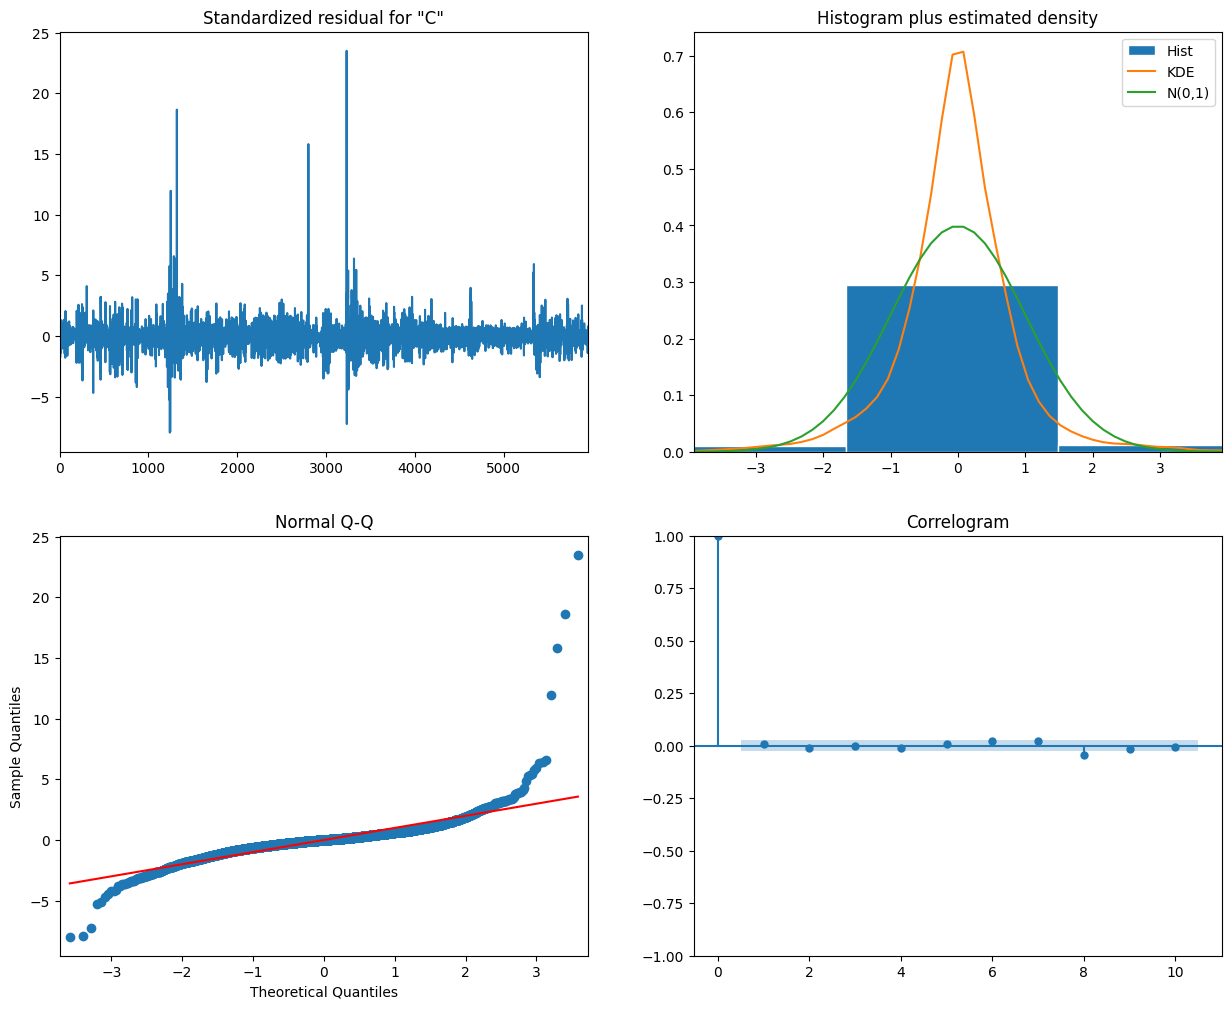

In [68]:
results.plot_diagnostics(figsize=(15,12))
plt.show()

In [69]:
prediction = results.get_forecast(30).predicted_mean.values
prediction = np.exp(prediction)
prediction

/home/kurone/anaconda3/envs/tsa/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/kurone/anaconda3/envs/tsa/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


array([0.34715827, 0.34707626, 0.3471827 , 0.3470991 , 0.34715265,
       0.34707895, 0.34712331, 0.34705814, 0.3470946 , 0.34703676,
       0.34706641, 0.34701489, 0.34703869, 0.3469926 , 0.34701135,
       0.34696995, 0.34698436, 0.34694698, 0.34695766, 0.34692375,
       0.34693121, 0.34690029, 0.34690498, 0.34687663, 0.34687894,
       0.3468528 , 0.34685306, 0.34682882, 0.34682731, 0.34680472])

In [70]:
test_df = pd.read_csv("./krwkzt-test.csv")
test_df["Close"] = test_df.Close.map(lambda x: np.float32(x.replace(",", ".")))
test_df["Date"] = test_df.Date.map(lambda x: pd.to_datetime(x, dayfirst=True).date())
test_df = test_df.set_index("Date")
test_df.head()

,Close
Date,
2023-11-01,0.348330
2023-11-02,0.349403
2023-11-03,0.352313
2023-11-04,0.352271
2023-11-05,0.352271


In [71]:
ground_truth = test_df["Close"].values
ground_truth

array([0.34832987, 0.34940252, 0.35231298, 0.35227144, 0.35227144,
       0.35701582, 0.3565124 , 0.35835826, 0.3563158 , 0.35279942,
       0.35332152, 0.35332152, 0.35301498, 0.3552217 , 0.3554606 ,
       0.35736582, 0.3561715 , 0.35613874, 0.35613874, 0.35904092,
       0.35383996, 0.3525469 , 0.3503616 , 0.35303703, 0.35208756,
       0.35214597, 0.35223144, 0.3538187 , 0.35591698, 0.3541214 ],
      dtype=float32)

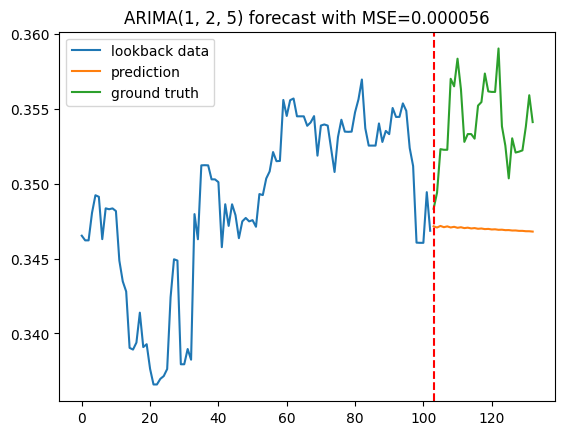

In [74]:
mse = mse_loss(torch.Tensor(prediction), torch.Tensor(ground_truth))
denormalized_data = df[-96-7:]["Close"].to_numpy()
num_lookback = denormalized_data.shape[0]

plt.plot(denormalized_data, label="lookback data")
plt.plot(np.concatenate([np.ones(num_lookback) * np.nan, prediction]), label='prediction')
plt.plot(np.concatenate([np.ones(num_lookback) * np.nan, ground_truth]), label='ground truth')
plt.title(f"ARIMA(1, 2, 5) forecast with MSE={mse:.6f}")
plt.axvline(x=denormalized_data.shape[0], c='r', linestyle='--')
plt.legend()
plt.show()

In [34]:
mse_loss(torch.Tensor(prediction), torch.Tensor(ground_truth))

tensor(5.4022e-05)

Optimal Lambda: -0.25463472061023606


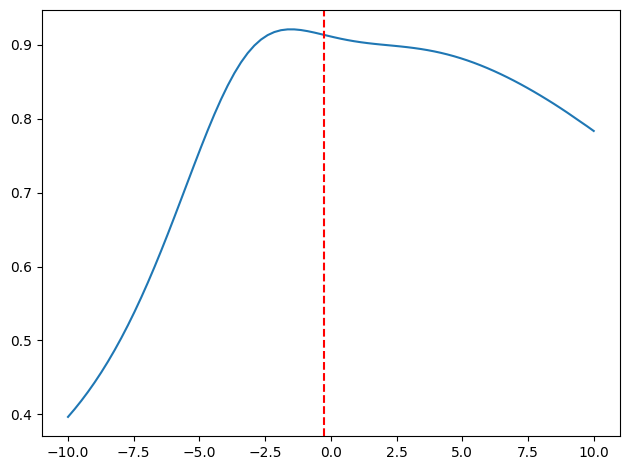

In [35]:
df_boxcox = df.copy()

# Parameter estimation of Box-Cox transformation
#Select the lambda (l_opt) with the highest normality by changing the lambda in a specific range (x) of the normal distribution
x, y = sp.stats.boxcox_normplot(df_boxcox["Close"], la=-10, lb=10) #Normalization Range (-6 ~ 6)

#Returns y and x values converted to normal distribution
y_transfer, l_opt = sp.stats.boxcox(df_boxcox["Close"])

print('Optimal Lambda:', l_opt)

plt.plot(x,y)
plt.axvline(x=l_opt, color='r', ls='--')
plt.tight_layout()
plt.show()

In [36]:
df_boxcox['Close'] = boxcox(df['Close'],lmbda=l_opt)
df_boxcox.head()

,Close
Date,
2004-01-02,-2.872750
2004-01-05,-2.887958
2004-01-06,-2.876652
2004-01-07,-2.892474
2004-01-08,-2.883747


In [37]:
#1st differencing with Box-Cox
diff_df_boxcox = df_boxcox.diff(periods=1).iloc[1:]

#2nd differencing with Box-Cox
diff_2_df_boxcox = df_boxcox.diff(periods=2).iloc[2:]

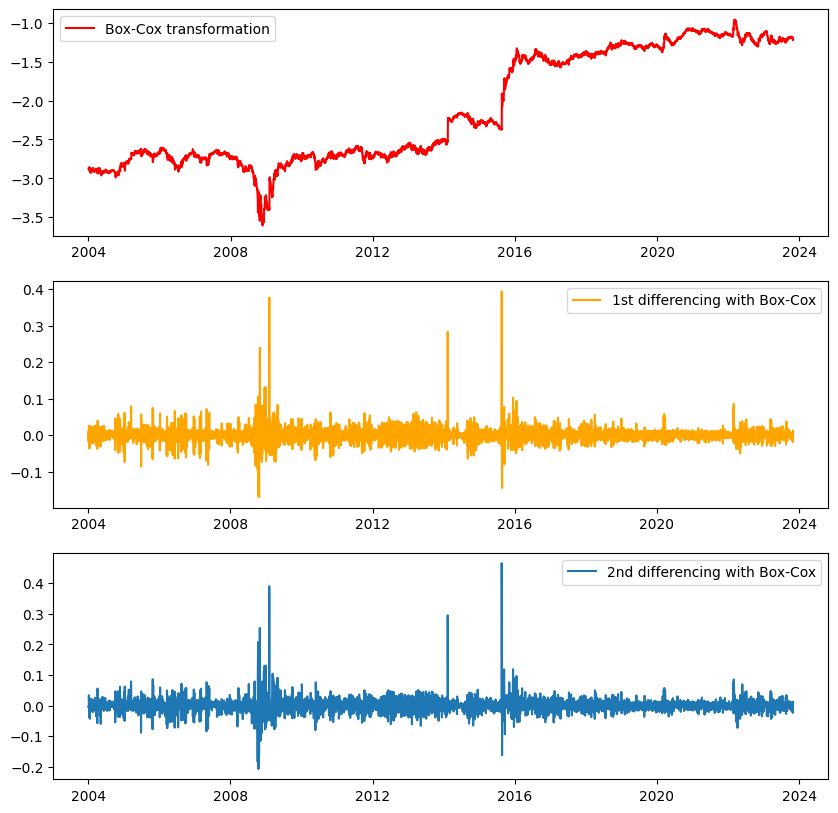

In [38]:
plt.figure(figsize=(10,10))

ax1 = plt.subplot(311)
ax1.plot(df_boxcox, color='red')
ax1.legend(['Box-Cox transformation'])


ax2 = plt.subplot(312)
ax2.plot(diff_df_boxcox, color='orange')
ax2.legend(['1st differencing with Box-Cox'])

ax3 =plt.subplot(313)
ax3.plot(diff_2_df_boxcox)
ax3.legend(['2nd differencing with Box-Cox'])

In [39]:
# ADF test

adf_test = adfuller(diff_df_boxcox)
adf_test_ = adfuller(diff_2_df_boxcox)

print('---1st differencing with Box-Cox---')
print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %20.20f' % adf_test[1])


print('\n---2nd differencing with Box-Cox---')
print('ADF Statistic: %f' % adf_test_[0])
print('Critical Values @ 0.05: %.2f' % adf_test_[4]['5%'])
print('p-value: %20.20f' % adf_test_[1])

---1st differencing with Box-Cox---
ADF Statistic: -11.819061
Critical Values @ 0.05: -2.86
p-value: 0.00000000000000000000

---2nd differencing with Box-Cox---
ADF Statistic: -11.511752
Critical Values @ 0.05: -2.86
p-value: 0.00000000000000000000


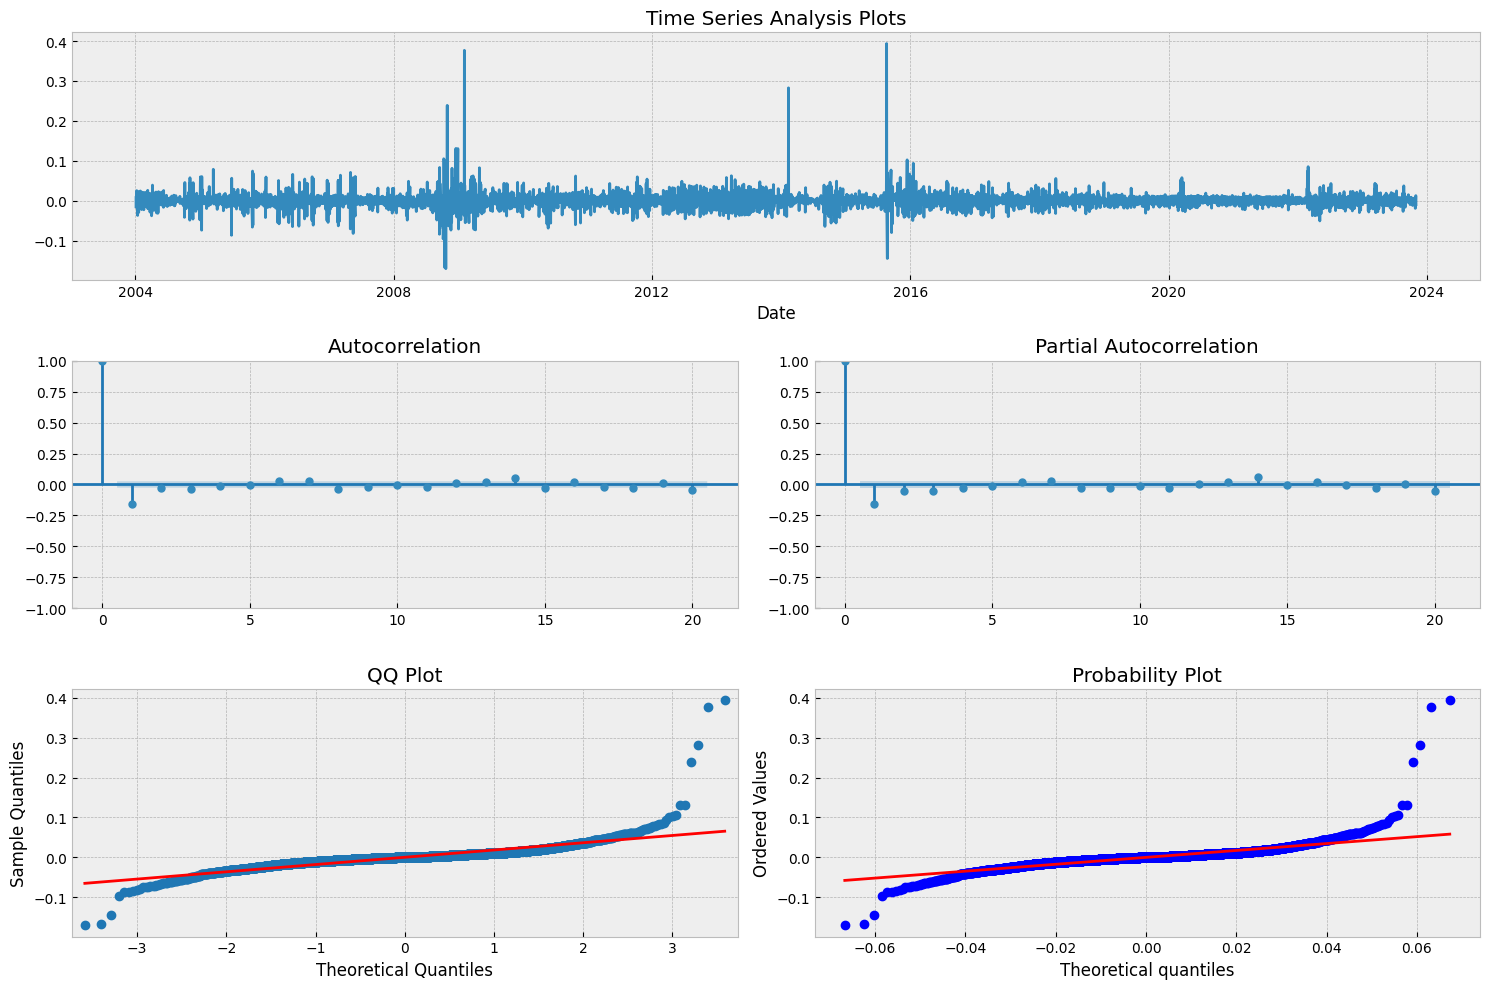

In [40]:
utils.tsplot(diff_df_boxcox["Close"], lags=20)

In [41]:
# The combination is for ARIMA order.

model = pm.auto_arima(df_boxcox, d=1,
                      start_p=0, start_q=0, max_order=6, test='adf',
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-30799.548, Time=0.52 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-30941.643, Time=0.39 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-30955.841, Time=1.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-30800.155, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-30967.450, Time=1.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-30939.909, Time=4.73 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-30966.778, Time=2.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-30963.574, Time=2.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-30954.696, Time=1.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-30966.449, Time=1.93 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-30967.027, Time=0.61 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 16.092 seconds


/home/kurone/anaconda3/envs/tsa/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/kurone/anaconda3/envs/tsa/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/kurone/anaconda3/envs/tsa/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5954
Model:                 ARIMA(1, 1, 1)   Log Likelihood               15486.513
Date:                Mon, 04 Dec 2023   AIC                         -30967.027
Time:                        21:43:00   BIC                         -30946.952
Sample:                             0   HQIC                        -30960.053
                               - 5954                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2256      0.029      7.790      0.000       0.169       0.282
ma.L1         -0.3901      0.026    -14.969      0.000      -0.441      -0.339
sigma2         0.0003   9.36e-07    344.002      0.0

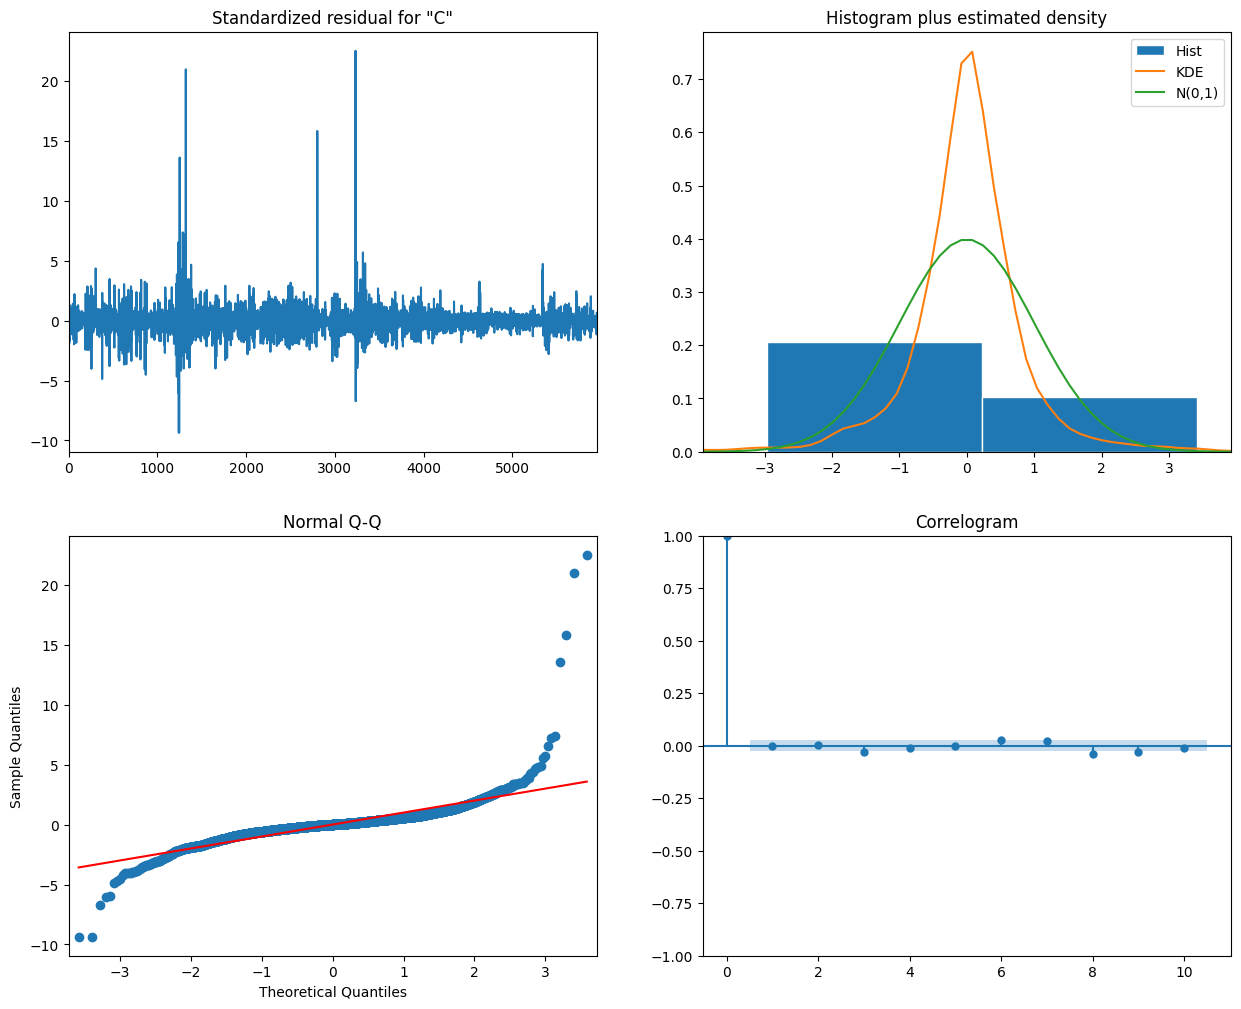

In [42]:
# create model
model = sm.tsa.arima.ARIMA(df_boxcox, order= (1,1,1))
results = model.fit()

print(results.summary())
results.plot_diagnostics(figsize=(15,12))
plt.show()

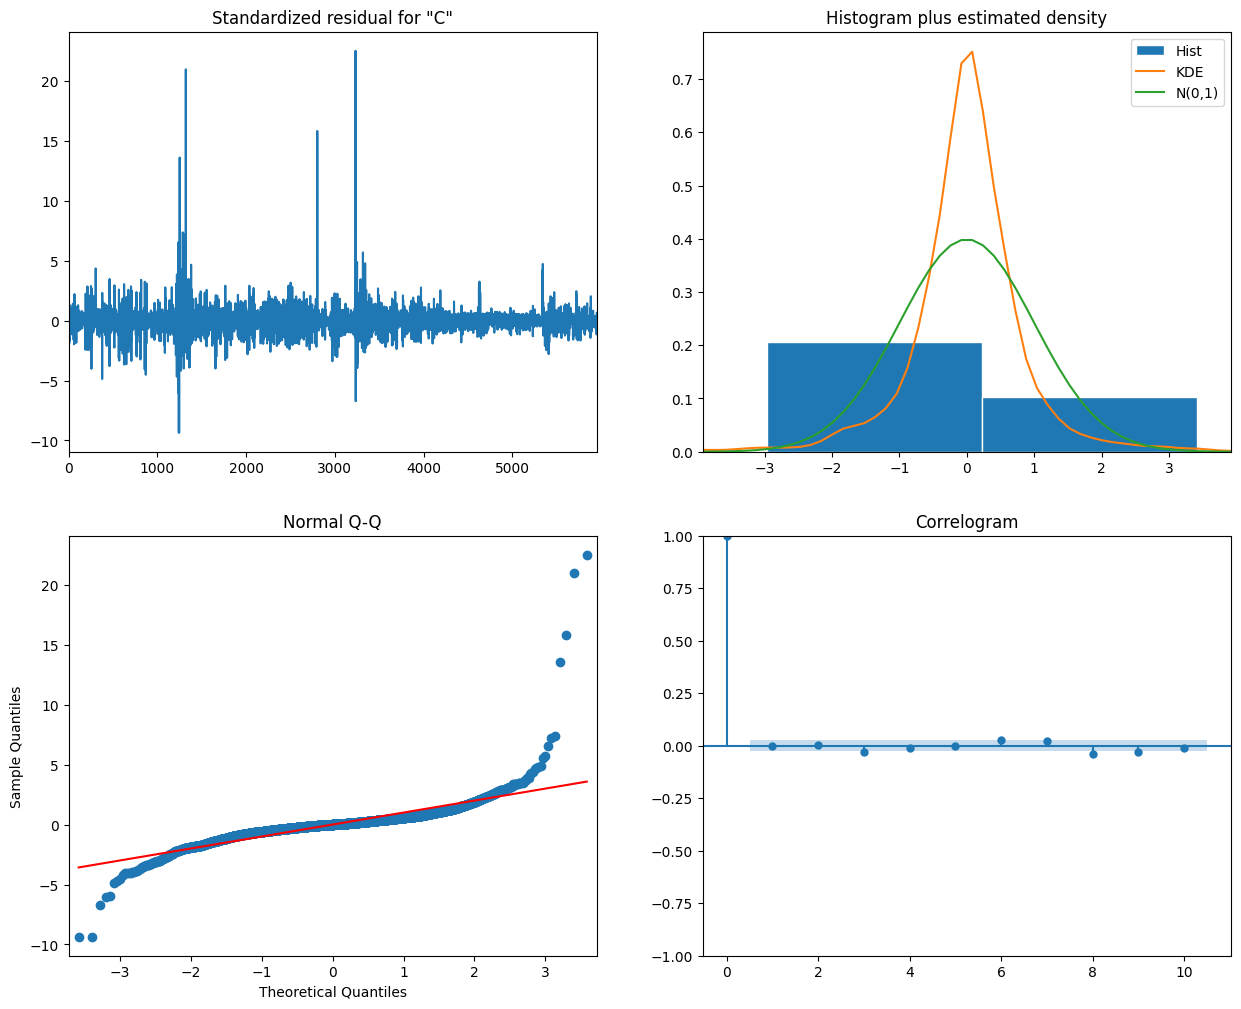

In [43]:
results.plot_diagnostics(figsize=(15,12))
plt.show()